In [117]:
import os, warnings
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib import image as mpimg

from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
warnings.filterwarnings("ignore")

In [2]:
train_path = 'data/PokemonTrainData' 
test_path = 'data/PokemonTestData'  

def print_pokemon_file(path, name):
    df = pd.DataFrame(columns=['Pokemon', name + ' Count'])

    for folder_name in os.listdir(path):
        folder_path = os.path.join(path, folder_name)
        
        if os.path.isdir(folder_path):
            file_list = os.listdir(folder_path)        
            num_files = len([f for f in file_list if os.path.isfile(os.path.join(folder_path, f))])
            df.loc[len(df)] = [folder_name, num_files]

    return df

In [3]:
train_data = print_pokemon_file(train_path, 'Train')
train_data

,Pokemon,Train Count
0,Squirtle,205
1,Pikachu,225
2,Charmander,213
3,Mewtwo,236
4,Bulbasaur,210


In [4]:
test_data = print_pokemon_file(test_path, 'Test')
test_data

,Pokemon,Test Count
0,Squirtle,47
1,Pikachu,57
2,Charmander,46
3,Mewtwo,49
4,Bulbasaur,36


In [6]:
data = pd.merge(left=train_data, right=test_data, how='outer', on='Pokemon')
data.head()

,Pokemon,Train Count,Test Count
0,Bulbasaur,210,36
1,Charmander,213,46
2,Mewtwo,236,49
3,Pikachu,225,57
4,Squirtle,205,47


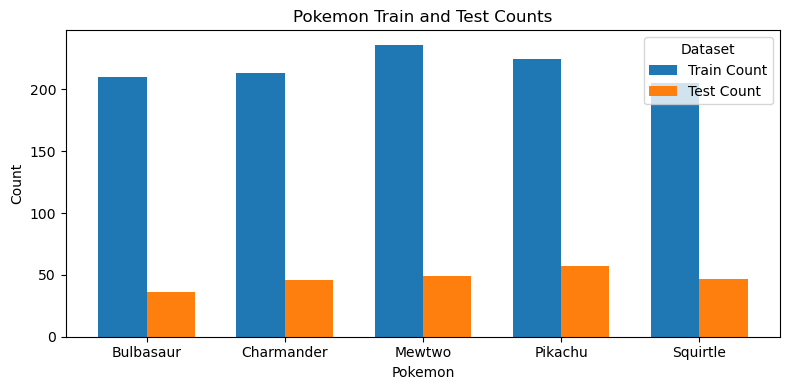

In [15]:
index = np.arange(len(data['Pokemon']))
bar_width = 0.35

plt.figure(figsize=(8, 4))
bars1 = plt.bar(index, data['Train Count'], bar_width, label='Train Count')
bars2 = plt.bar(index + bar_width, data['Test Count'], bar_width, label='Test Count')

plt.title('Pokemon Train and Test Counts')
plt.xlabel('Pokemon')
plt.ylabel('Count')
plt.xticks(index + 0.35 / 2, data['Pokemon'])  
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()

(900, 900, 4)


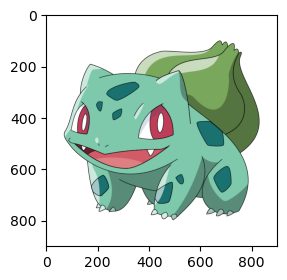

In [17]:
img_path = 'data/PokemonTestData/Bulbasaur/00000000.png'    
img = mpimg.imread(img_path)
print(img.shape)
plt.figure(figsize=(5, 3))
plt.imshow(img)
plt.show()

## Training

In [153]:
TRAIN_DIR = 'data/PokemonTrainData'
TEST_DIR = 'data/PokemonTestData'
num_classes = data['Pokemon'].nunique()
img_shape = (128, 128)

In [159]:
# Ajouter des transformations d'augmentation des données
#train_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)
datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,  # Rotation aléatoire de 20 degrés
    width_shift_range=0.2,  # Décalage horizontal aléatoire
    height_shift_range=0.2,  # Décalage vertical aléatoire
    shear_range=0.2,  # Cisaillement aléatoire
    zoom_range=0.2,  # Zoom aléatoire
    horizontal_flip=True,  # Retournement horizontal aléatoire
    fill_mode='nearest',  # Remplissage des pixels vides après transformation
    validation_split=0.2,  # Fraction des données utilisée pour la validation
    #color_mode='grayscale' # Convertir les images en niveaux de gris
)


# Chargement des images d'entraînement avec augmentation
train_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=img_shape,  # Resize images to this size
    batch_size=32,  # Number of images to be yielded from the generator per batch
    class_mode='categorical',  # For multi-class classification
    subset='training',
    #color_mode='grayscale'  # Conversion en niveaux de gris
)


# Chargement des images de validation
validation_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=img_shape,
    batch_size=32,
    class_mode='categorical',
    subset='validation',  # Specify this subset is for validation
    subset='validation',
    #color_mode='grayscale'  # Conversion en niveaux de gris
)

Found 1088 images belonging to 5 classes.
Found 216 images belonging to 5 classes.


## Piste

- Convertir les images en niveaux de gris dans datagen, train_generator, validation_generator
    - puis dans la première couche du modèle, input_shape=(128, 128, 1)

## Model

In [161]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(40, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
#model.add(Dense(train_generator.num_classes, activation='softmax'))

In [163]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 61, 61, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 28, 28, 40)     │        11,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 14, 14, 40)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 7840)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │     4,014,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,038,861 (15.41 MB)

 Trainable params: 4,038,861 (15.41 MB)

 Non-trainable params: 0 (0.00 B)

In [165]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'f1_score'])

In [199]:
history = model.fit(train_generator, epochs=10, verbose=True, validation_data=validation_generator)

Epoch 1/10


2024-10-08 22:42:30.437207: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:80: Filling up shuffle buffer (this may take a while): 1 of 8
2024-10-08 22:42:48.935518: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:80: Filling up shuffle buffer (this may take a while): 2 of 8
2024-10-08 22:43:06.602749: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:80: Filling up shuffle buffer (this may take a while): 3 of 8
2024-10-08 22:43:24.046358: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:80: Filling up shuffle buffer (this may take a while): 4 of 8
2024-10-08 22:43:43.510650: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:80: Filling up shuffle buffer (this may take a while): 5 of 8
2024-10-08 22:44:03.080952: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:80: Filling up shuffle buffer (this may take a while): 6 of 8
2024-10-08

34/34 ━━━━━━━━━━━━━━━━━━━━ 590s 13s/step - accuracy: 0.9046 - f1_score: 0.8997 - loss: 0.2786 - val_accuracy: 0.9815 - val_f1_score: 0.9816 - val_loss: 0.0572
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 35s 879ms/step - accuracy: 0.9364 - f1_score: 0.9366 - loss: 0.1761 - val_accuracy: 0.9907 - val_f1_score: 0.9907 - val_loss: 0.0558
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 34s 851ms/step - accuracy: 0.9592 - f1_score: 0.9588 - loss: 0.1177 - val_accuracy: 0.9815 - val_f1_score: 0.9818 - val_loss: 0.0629
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 34s 830ms/step - accuracy: 0.9753 - f1_score: 0.9753 - loss: 0.0985 - val_accuracy: 0.9861 - val_f1_score: 0.9858 - val_loss: 0.0423
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 33s 837ms/step - accuracy: 0.9857 - f1_score: 0.9856 - loss: 0.0615 - val_accuracy: 1.0000 - val_f1_score: 1.0000 - val_loss: 0.0137
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 34s 859ms/step - accuracy: 0.9860 - f1_score: 0.9858 - loss: 0.0459 - val_accuracy: 1.0000 - val_f1_score: 1.0000 - val

In [204]:
history.history

{'accuracy': [0.9172794222831726,
  0.9476103186607361,
  0.9623161554336548,
  0.9715073704719543,
  0.9806985259056091,
  0.9834558963775635,
  0.9908088445663452,
  0.9963235259056091,
  0.9990808963775635,
  0.998161792755127],
 'f1_score': [<tf.Tensor: shape=(5,), dtype=float32, numpy=
  array([0.944844 , 0.9245282, 0.9358178, 0.8986783, 0.879397 ],
        dtype=float32)>,
  <tf.Tensor: shape=(5,), dtype=float32, numpy=
  array([0.93809515, 0.9622641 , 0.9623431 , 0.9466666 , 0.9257425 ],
        dtype=float32)>,
  <tf.Tensor: shape=(5,), dtype=float32, numpy=
  array([0.97852015, 0.96941173, 0.9599999 , 0.9619686 , 0.94146335],
        dtype=float32)>,
  <tf.Tensor: shape=(5,), dtype=float32, numpy=
  array([0.9786223 , 0.9718309 , 0.97033894, 0.97117513, 0.9655171 ],
        dtype=float32)>,
  <tf.Tensor: shape=(5,), dtype=float32, numpy=
  array([0.9880096 , 0.976415  , 0.99365747, 0.9647576 , 0.9803921 ],
        dtype=float32)>,
  <tf.Tensor: shape=(5,), dtype=float32, numpy

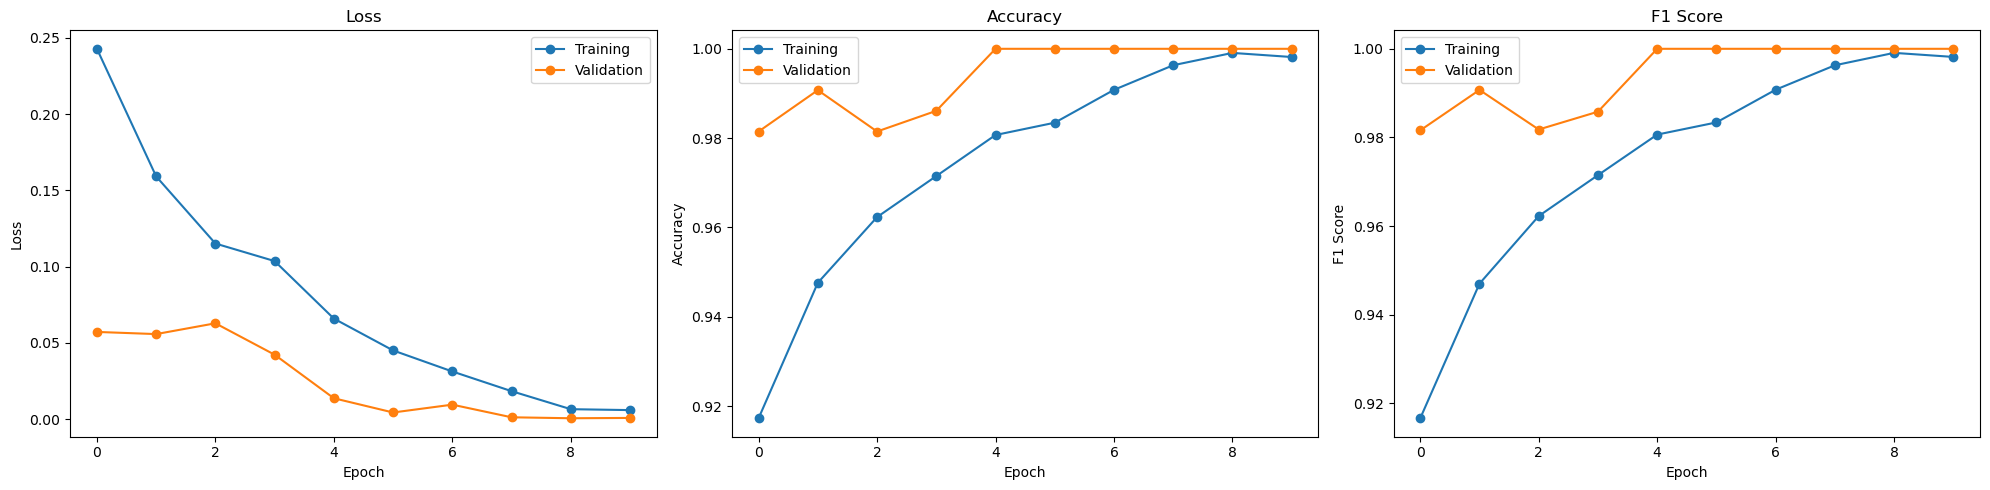

In [212]:
f1_score_train = [f1.numpy().mean() for f1 in history.history['f1_score']]
val_f1_score_score_train = [f1.numpy().mean() for f1 in history.history['val_f1_score']]

plt.figure(figsize=(20, 5))

# Plot Loss
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training', marker='o')
plt.plot(history.history['val_loss'], label='Validation', marker='o')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Training', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation', marker='o')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot F1 Score
plt.subplot(1, 3, 3)
plt.plot(f1_score_train, label='Training', marker='o')
plt.plot(val_f1_score_score_train, label='Validation', marker='o')
plt.title('F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

This output shows that your model is converging well during training and achieving excellent performance on both the training and validation datasets. However, high accuracy on validation data suggests the need to carefully check the generalization capabilities of your model on new, unseen data.